In [ ]:
#How to structure data for script

#.
#└── DATA_PATH
#    ├── FOLDER1
#    │   ├── CT_FILE_1.dcm
#    │   ├── CT_FILE_2.dcm
#         ......
#    │   ├── RP_FILE.dcm
#    │   └── RS_FILE.dcm
#    ├── FOLDER2
#    │   ├── CT_FILE_1.dcm
#         ...... etc

In [11]:
import importlib

import numpy as np

import matplotlib.pyplot as plt

import skimage.transform

import skimage.draw

import dicom_process

import helpers

importlib.reload(dicom_process)
importlib.reload(helpers)

plt.rcParams['figure.figsize'] = [6, 6]

# Choose case:

In [12]:
# Vet case
DATA_PATH = "/home/matthew/proj/masters-project/pymedphys-segmentation/open_datasets/VET_DATASET_CLEAN/"
# Structure masks to be pulled
STRUCTURE_NAMES = ["patient", "Vacbag", "vacbag", "Couch Foam Half Couch", "Couch Outer Half Couch", "Couch Edge"]

In [13]:
# Prostate case
#DATA_PATH = "/home/matthew/priv/PROSTATE_TEST/"
# Structure masks to be pulled
#STRUCTURE_NAMES = ["patient", "RT HOF", "LT HOF", "BLADDER", "RECTUM", "Couch Foam Half Couch", "Couch Outer Half Couch", "Couch Edge"]

In [14]:
# Resize images
SIZE = 64, 64
# Number of additional context image slices for each (image, label) input
# ie. input_instance = image +- CONTEXT neighbouring images
CONTEXT = 10

# For viewing:

In [37]:
# Choose a patient folder from data_folders
FOLDER_INDEX = 0
# Choose a z slice index
SLICE_INDEX = 100

# Automated data processing overview:
### NOTE: See # LIMIT TO ONLY SOME FOLDERS TO MAKE EXAMPLE QUICKER (below)

#### [ ] TODO: Have not added cleaning structures (via STRUCTURE_NAMES) to automated process - only manual (below automated)
#### [ ] TODO: Only returns one structure but an easy fix by appending
#### [ ] TODO Account for fact that multiple ROIs per xyz index
#### [ ] TODO: Save data for each case when building trainning data as does not all will fit in memory
#### NOTE: These TODOs are outlined in the manual section (below)



In [38]:
data_folders = dicom_process.list_files(DATA_PATH, None)

# LIMIT TO ONLY SOME FOLDERS TO MAKE EXAMPLE QUICKER
data_folders = data_folders[0:1]

loaded_data = []

for index, folder in enumerate(data_folders):
    print(f"----------------")
    print(f"LOADING: {index+1}/{len(data_folders)}")
    print(f"{folder}")
    try:
        images, labels, colors, structures = dicom_process.get_input_data(folder, SIZE, CONTEXT)
    except IndexError:
        print(f"WARNING: IndexError")
        pass
    
    # probably want to get context and the save each (input_instance, label) 
    # set in folder as total data in all folders in data_folders is too large for memerory
    loaded_data.append([images, labels, colors, structures])
        
print(f"================")
print(f"LOADING COMPLETE")

----------------
LOADING: 1/1
/home/matthew/proj/masters-project/pymedphys-segmentation/open_datasets/VET_DATASET_CLEAN/13950
LOADING COMPLETE


Folder: /home/matthew/proj/masters-project/pymedphys-segmentation/open_datasets/VET_DATASET_CLEAN/13950


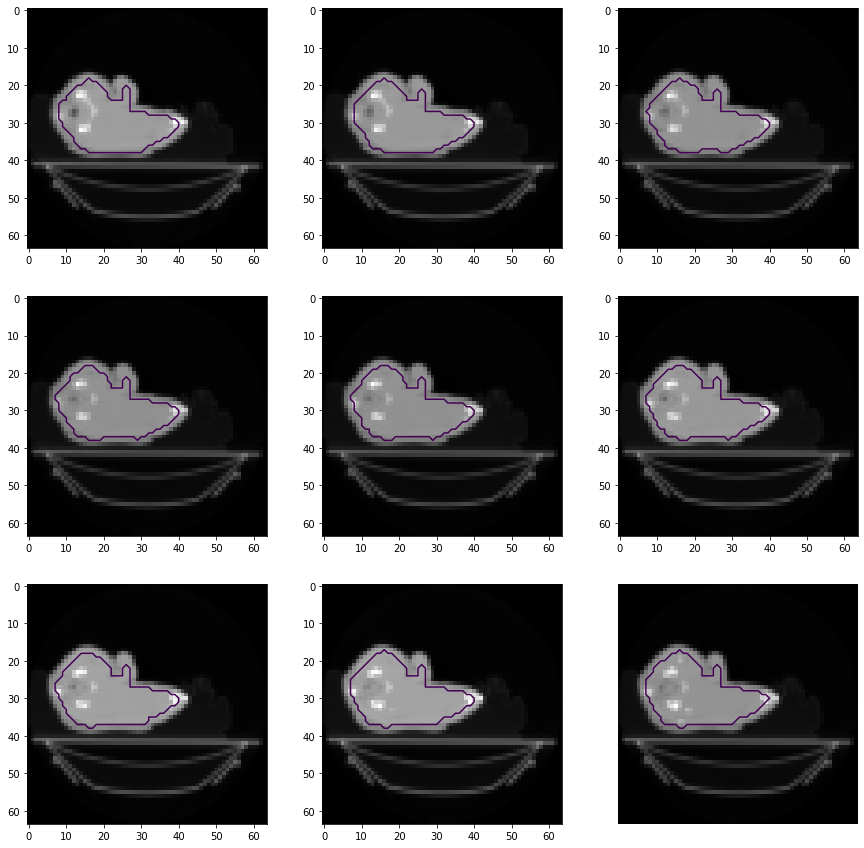

In [39]:
print(f"Folder: {data_folders[FOLDER_INDEX]}")
images, labels, *rest = loaded_data[FOLDER_INDEX]
helpers.plot_model_data(images, labels, index=SLICE_INDEX, slices=9, corners=False)

In [40]:
# so far this only contains one label - need to rework so adds all - TODO above
print(len(labels))
print(labels.shape)

233
(233, 64, 64)


## Lets examine the structure labels in our data

In [41]:
for index, data in enumerate(loaded_data):
    structures = data[3]
    print(data_folders[index])
    helpers.print_structures(structures)
    print("----------------------------")
    

/home/matthew/proj/masters-project/pymedphys-segmentation/open_datasets/VET_DATASET_CLEAN/13950
structures[0]: structure numer 1 - patient - color ['"220"', '"160"', '"120"']
structures[1]: structure numer 9 - GTV - color ['"255"', '"128"', '"0"']
structures[2]: structure numer 10 - CTV - color ['"0"', '"0"', '"255"']
structures[3]: structure numer 11 - PTV - color ['"255"', '"0"', '"0"']
structures[4]: structure numer 12 - Cord - color ['"64"', '"0"', '"128"']
structures[5]: structure numer 13 - Cord PRV - color ['"128"', '"0"', '"255"']
structures[6]: structure numer 19 - Urethra - color ['"0"', '"128"', '"128"']
structures[7]: structure numer 20 - Bladder - color ['"255"', '"255"', '"0"']
structures[8]: structure numer 22 - Rectum - color ['"128"', '"64"', '"0"']
structures[9]: structure numer 23 - LN - color ['"128"', '"64"', '"0"']
structures[10]: structure numer 24 - PTV_LN - color ['"255"', '"128"', '"255"']
structures[11]: structure numer 26 - Vacbag - color ['"128"', '"128"', 

--------------------------------------------
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Manual data processing overview

In [42]:
# Load for a single folder in data_folder - FOLDER_INDEX

folder = dicom_process.list_files(DATA_PATH, None)[FOLDER_INDEX]

file_names = dicom_process.list_files(folder, ".dcm")

dicom_files = dicom_process.read_dicom_files(file_names)
dicom_series, dicom_structures, *rest = dicom_process.filter_dicom_files(dicom_files)
dicom_series = dicom_process.add_transfer_syntax(dicom_series)
dicom_series.sort(key=lambda x: float(x.ImagePositionPatient[2]))

## Some basic data to examine

In [43]:
helpers.print_dicom_slice_data(dicom_series[0])
# np.uint16 - Unsigned integer (0 to 65535)

AnatomicalOrientationType: None - Assume BIPED not QUADRUPED
PatientPosition: FFP
 
ImageOrientationPatient: ['1', '0', '0', '0', '-1', '0']
PixelSpacing [x,y] - Scaling factors: ['0.974609375', '0.974609375']
PixelSpacing [z] - Scaling factors: 2.00
ImagePositionPatient [x,y,z] (patient space) - Translation factors: ['-249.5', '47.5', '-152.5']
 
SliceLocation (z patient space): 152.50
SliceThickness: 2.00
 
type in pixel_array: <class 'numpy.uint16'>


In [44]:
z_slice_locations = np.array([dicom.ImagePositionPatient[2] for dicom in dicom_series])
print(z_slice_locations)

[-152.5 -150.5 -148.5 -146.5 -144.5 -142.5 -140.5 -138.5 -136.5 -134.5
 -132.5 -130.5 -128.5 -126.5 -124.5 -122.5 -120.5 -118.5 -116.5 -114.5
 -112.5 -110.5 -108.5 -106.5 -104.5 -102.5 -100.5  -98.5  -96.5  -94.5
  -92.5  -90.5  -88.5  -86.5  -84.5  -82.5  -80.5  -78.5  -76.5  -74.5
  -72.5  -70.5  -68.5  -66.5  -64.5  -62.5  -60.5  -58.5  -56.5  -54.5
  -52.5  -50.5  -48.5  -46.5  -44.5  -42.5  -40.5  -38.5  -36.5  -34.5
  -32.5  -30.5  -28.5  -26.5  -24.5  -22.5  -20.5  -18.5  -16.5  -14.5
  -12.5  -10.5   -8.5   -6.5   -4.5   -2.5   -0.5    1.5    3.5    5.5
    7.5    9.5   11.5   13.5   15.5   17.5   19.5   21.5   23.5   25.5
   27.5   29.5   31.5   33.5   35.5   37.5   39.5   41.5   43.5   45.5
   47.5   49.5   51.5   53.5   55.5   57.5   59.5   61.5   63.5   65.5
   67.5   69.5   71.5   73.5   75.5   77.5   79.5   81.5   83.5   85.5
   87.5   89.5   91.5   93.5   95.5   97.5   99.5  101.5  103.5  105.5
  107.5  109.5  111.5  113.5  115.5  117.5  119.5  121.5  123.5  125.5
  127.

In [45]:
# moving slice locations from patient space to pixel space (image space)
((z_slice_locations - np.min(z_slice_locations)) / dicom_series[0].SliceThickness)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

## Images

In [46]:
images = dicom_process.get_pixel_array(dicom_series)

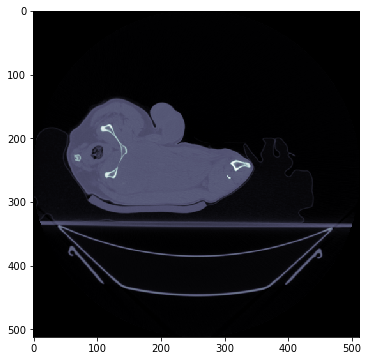

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

min:0
max:4000


In [47]:
# View single image data
helpers.plot_pixel_array(images[SLICE_INDEX])
helpers.print_range(images)

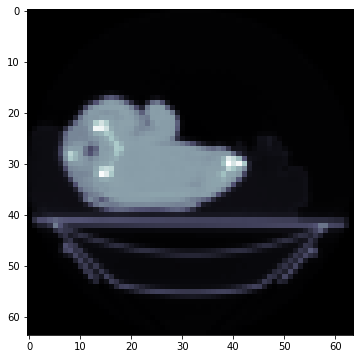

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

min:0.0
max:0.03536659800106813


In [48]:
# View single image data - resized
images_resized = dicom_process.resize_pixel_array(images, SIZE)
helpers.plot_pixel_array(images_resized[SLICE_INDEX])
helpers.print_range(images_resized)

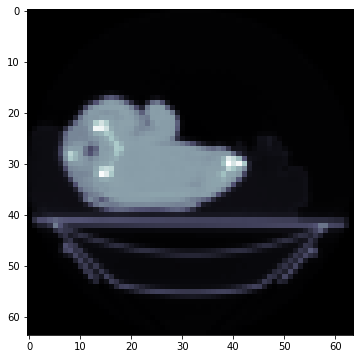

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

min:0.0
max:1.96733231691274e-310


In [49]:
# View single image data - resized and normalised
images_resized_normal = dicom_process.normalise_pixel_array_volume(images_resized)
helpers.plot_pixel_array(images_resized_normal[SLICE_INDEX])
helpers.print_range(images_resized_normal)

## Structures

In [50]:
# Structures from a folder in data_folder
# Note dicom_structures is returned as a like like dicom_series
# to get the first RS dicom file found use the first index dicom_structures[0]
structures = dicom_process.read_structures(dicom_structures[0])
helpers.print_structures(structures)

structures[0]: structure numer 1 - patient - color ['"220"', '"160"', '"120"']
structures[1]: structure numer 9 - GTV - color ['"255"', '"128"', '"0"']
structures[2]: structure numer 10 - CTV - color ['"0"', '"0"', '"255"']
structures[3]: structure numer 11 - PTV - color ['"255"', '"0"', '"0"']
structures[4]: structure numer 12 - Cord - color ['"64"', '"0"', '"128"']
structures[5]: structure numer 13 - Cord PRV - color ['"128"', '"0"', '"255"']
structures[6]: structure numer 19 - Urethra - color ['"0"', '"128"', '"128"']
structures[7]: structure numer 20 - Bladder - color ['"255"', '"255"', '"0"']
structures[8]: structure numer 22 - Rectum - color ['"128"', '"64"', '"0"']
structures[9]: structure numer 23 - LN - color ['"128"', '"64"', '"0"']
structures[10]: structure numer 24 - PTV_LN - color ['"255"', '"128"', '"255"']
structures[11]: structure numer 26 - Vacbag - color ['"128"', '"128"', '"255"']
structures[12]: structure numer 27 - PTVeval - color ['"128"', '"255"', '"255"']
struct

In [51]:
# clean the structures
structures = dicom_process.clean_structures(structures, STRUCTURE_NAMES)
helpers.print_structures(structures)

structures[0]: structure numer 1 - patient - color ['"220"', '"160"', '"120"']
structures[1]: structure numer 26 - Vacbag - color ['"128"', '"128"', '"255"']
structures[2]: structure numer 34 - Couch Edge - color ['"164"', '"255"', '"187"']
structures[3]: structure numer 35 - Couch Foam Half Couch - color ['"255"', '"0"', '"128"']
structures[4]: structure numer 36 - Couch Outer Half Couch - color ['"64"', '"0"', '"128"']


In [52]:
# how my dicts work
patient = structures[0]
print(patient.keys())

dict_keys(['number', 'name', 'contour_points', 'color'])


In [53]:
# extracting contour points
patient_xyz = patient['contour_points']
z_slice_contour_data = patient_xyz[0]
xyz_points = np.array(z_slice_contour_data).reshape((-1, 3))
print(xyz_points[0:10])

[[  50.6 -184.8  -56.5]
 [  50.9 -184.5  -56.5]
 [  51.6 -184.5  -56.5]
 [  51.9 -184.5  -56.5]
 [  52.6 -184.5  -56.5]
 [  52.9 -184.5  -56.5]
 [  53.6 -184.5  -56.5]
 [  53.9 -184.5  -56.5]
 [  54.6 -184.5  -56.5]
 [  54.9 -184.5  -56.5]]


In [54]:
labels = dicom_process.get_binary_masks(structures, dicom_series, images)

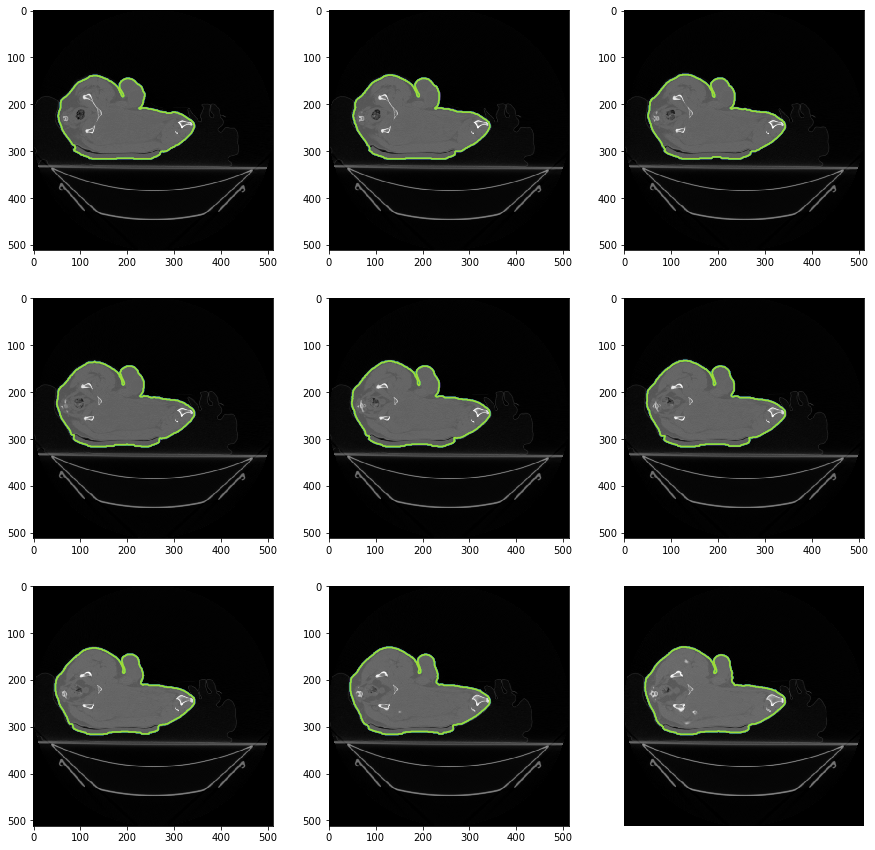

In [55]:
helpers.plot_model_data(images, labels, SLICE_INDEX)

--------------------
<br><br><br><br><br>
# Below is code in progress


#### [ ] TODO Mask that includes all labels
#### [ ] TODO Account for fact that multiple ROIs per xyz index

In [34]:
def transform_to_array(x, y, dicom_series):
    """
    Transform from patient space to pixel space
    """
    translation = dicom_series[0].ImagePositionPatient
    scale = dicom_series[0].PixelSpacing
    orientation = dicom_series[0].ImageOrientationPatient
    x = np.array(x)
    y = np.array(y)

    # NOTE Only handles +-1 cosines
    # A more robust method that handles intermediate angels
    # was attempted however the affine matrix was singular
    # See: http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.htmlx1
    # See: https://dicomiseasy.blogspot.com/2013/06/getting-oriented-using-image-plane.html
    r = (y - translation[1]) / scale[1] * orientation[4]
    c = (x - translation[0]) / scale[0] * orientation[0]

    return r, c

In [35]:
def get_binary_masks(structures, dicom_series):
    for slice_index in range(len(dicom_series[:])):        
        for structure in structures[:]:
            xyz = structure['contour_points'][slice_index]
           # r, c = dicom_process.transform_to_array(x, y, dicom_series)
            #rr, cc = skimage.draw.polygon(r, c)
    return None

In [36]:
get_binary_masks(structures, dicom_series)

IndexError: list index out of range

In [ ]:
for slice_index in range(len(dicom_series)):
    print(slice_index, structures[1]['contour_points'][slice_index][2])

In [ ]:
x = structures[1]['contour_points'][10][0::3]
y = structures[1]['contour_points'][10][1::3]
z = structures[1]['contour_points'][10][2::3]
print(z[0])
r, c = transform_to_array(x, y, dicom_series)
img1 = np.zeros((512, 512), dtype=np.uint16)
rr, cc = skimage.draw.polygon(r, c)
img1[rr, cc] = 1
plt.imshow(img1)

In [ ]:
x = structures[1]['contour_points'][11][0::3]
y = structures[1]['contour_points'][11][1::3]
z = structures[1]['contour_points'][11][2::3]
print(z[0])
r, c = transform_to_array(x, y, dicom_series)
img2 = np.zeros((512, 512), dtype=np.uint16)
rr, cc = skimage.draw.polygon(r, c)
img2[rr, cc] = 1

In [ ]:
index = 85
print(dicom_series[index].ImagePositionPatient[2])
plt.imshow(images[index], cmap="gray")
plt.contour(img1, colors='red')
plt.contour(img2, colors='blue')

In [ ]:
labels = get_binary_masks(structures, dicom_series, images)
print(labels.shape)
helpers.plot_model_data(images, labels, SLICE_INDEX-10)

--------------------
#### [ ]  TODO Getting context and saving input instances to load later into model

In [ ]:
def get_context(pixel_array_volume, index, context=10):
    """
    # TODO write docstring
    """
    return pixel_array_volume[index - context:index + context + 1]

In [ ]:
OUTPUT_PATH = "/home/matthew/proj/masters-project/pymedphys-segmentation/open_datasets/model_data/"
context = 10
for index in range(len(images)):
    temp = get_context(images, index, context)
    # skip those that dont have enough padding
    # this is a quick and dirt hack to be fixed
    if temp.shape[0] == 1 + 2 * context:
        input_instance = temp
        label_instance = labels[index]
        data_instance = [input_instance, label_instance]

In [ ]:
plt.imshow(label_instance)